# About
Quick experiments comparing performances of multi-armed bandit algorithms over short time horizons.

## Motivation

Many notes/papers that compare the performances of Bernoulli (Multi-Arm) Bandit strategies show results over very long time horizons, e.g. 10,000 steps.  I'm curious about how algorithms perform over very short time horizons < ~ 100 steps. (That's more similar to human players who have a very limited time to play.)  

I also want to verify the claim in the paper [Multi-Armed Bandit Algorithms and Empirical
Evaluation](https://cs.nyu.edu/~mohri/pub/bandit.pdf) that simple algorithms like Epsilon-Greedy can be surprisingly competitive to more sophisticated algorithms.
  * So in these notes, compare Epsilon Greedy Algorithms vs a more sophisticated Thompson Sampling.

I'm also interested situations where there is a modest number of arms, ~ 5, and 1 arm has a higher probability of payout than the other arms.  This models everyday situations faced by humans, who must make choices between a modest # of alternatives, one of which is superior to others, with a limited amount of time to gather evidence of rewards. (Note: if all of the probabilities of payout are roughly the same, then it doesn't matter very much which arm you pull over short games. So focus on cases where 1 arm is more rewarding than others.) Are there any simple algorithms that work really well in this situation?

## Other references
Interesting: [Optimal Policy for Bernoulli Bandits: Computation and Algorithm Gauge](https://ieeexplore.ieee.org/document/9408359) derives optimal solutions.  
(Not implemented here yet.)


In [1]:
%matplotlib widget

In [2]:
import numpy as np
from abc import ABC, abstractmethod
from typing import Optional
import matplotlib.pyplot as plt

In [3]:
RNG_SEED = 12345
np.random.seed(RNG_SEED)

In [4]:
def argmax_rnd_tie_breaking(x):
  #like to np.argmax(x), but randomly breaks ties. Useful to add more randomness when values may be duplicated.
  y = np.array(x)
  return np.random.choice(np.flatnonzero(y == y.max()))

class Bandit(ABC):
  @abstractmethod
  def get_reward(self, i: int):
    raise NotImplementedError()

class BernoulliBandit(Bandit):
  def __init__(self, num_arms: int, probs: list[float]):
    if len(probs) != num_arms:
      raise ValueError("num_arms must be positive int, probs must be list of floats whose length = num_arms")
    self.num_arms = num_arms
    self.probs = probs
    self.prob_max = np.max(probs)
    self.arm_best = np.argmax(probs)
    
  def get_reward(self, arm_indx: int): #in range 0 to (K-1)
    return 1 if np.random.random() < self.probs[arm_indx] else 0
    
  def get_all_rewards(self):  #Returns rewards for any arm pulled. Implemented so we can test multiple solvers at once
    rnds = np.random.random(self.num_arms)
    rewards = [1 if rnd < prob else 0 for rnd, prob in zip(rnds, self.probs)]
    return rewards

#-------------------------

class Agent(ABC):
  def __init__(self, bandit: Bandit, name: str):
    self.num_arms = bandit.num_arms  #number of arms
    self.name = name
    self.reset()

  def reset(self):
    self.successes = [0]*self.num_arms
    self.failures = [0]*self.num_arms
    self.num_pulls = [0]*self.num_arms
    self.num_pulls_total = 0
    self.estimated_probs = [0.0]*self.num_arms
    self.total_reward = 0

  def estimate_prob(self, arm):
    """Update estimated probabilites for the arm that was pulled"""
    if self.num_pulls == 0:
      self.estimated_probs[arm] = 0.0
    else:
      self.estimated_probs[arm] = self.successes[arm] / self.num_pulls[arm]

  def store_pull_results(self, arm: int, reward: int, step: Optional[int] = None):
    self.num_pulls_total += 1
    self.num_pulls[arm] += 1
    if reward == 1:
      self.successes[arm] +=1
    else:
      self.failures[arm] += 1

    self.estimate_prob(arm)
    self.total_reward += reward
      
  @abstractmethod
  def get_arm_to_pull(self, step: int):
    raise NotImplementedError() #return index of arm to pull, based on algorithm used by the specific agent

#------------------

class GreedyAgent(Agent):
  """Naive Greedy agent: Does a fixed number of exploration steps at the beginning
     and then continuously pulls best arm found in initial exploration phase."""
  def __init__(self, bandit: Bandit, num_search_steps_per_arm: int, name: str):
    super().__init__(bandit, name)
    
    if not num_search_steps_per_arm > 0:
      raise ValueError("num_search_steps_per_arm must be positive int")
      
    self.num_search_steps_per_arm = num_search_steps_per_arm
    self.num_search_steps_total = self.num_arms * self.num_search_steps_per_arm

  def get_arm_to_pull(self, step: int):
    if step < self.num_search_steps_total:
      #still in initial exploration mode
      arm_indx = step // self.num_search_steps_per_arm 
    else:
      if step == self.num_search_steps_total:
        
        #self.best_arm = np.argmax(self.estimated_probs)  #only computed once!
        self.best_arm = argmax_rnd_tie_breaking(self.estimated_probs)

      arm_indx = self.best_arm
      
    return arm_indx

#------------------

class EpsilonGreedyAgent(Agent):
  """Does a fixed number of exploration steps at the beginning,
     then mostly greedily pulls best arm found to date, but continues to explore
     with probability epsilon."""
  def __init__(self, bandit: Bandit, num_search_steps_per_arm: int, epsilon: float, name: str):
    super().__init__(bandit, name)
    if not num_search_steps_per_arm > 0:
      raise ValueError("num_search_steps_per_arm must be positive int")
    if not (epsilon >= 0.0 and epsilon <= 1.0):
      raise ValueError("epsilon must be float between 0 and 1")

    self.num_search_steps_per_arm = num_search_steps_per_arm
    self.num_initial_search_steps_total = self.num_arms * self.num_search_steps_per_arm
    self.epsilon = epsilon

  def get_arm_to_pull(self, step: int):
    if step < self.num_initial_search_steps_total:
      #still in initial exploration mode
      arm_indx = step // self.num_search_steps_per_arm 
    else:
      if np.random.random() < self.epsilon:
        #random exploration
        arm_indx = np.random.randint(0, self.num_arms)
      else:
        #get best arm using current probability estimates
        #arm_indx = np.argmax(self.estimated_probs)
        arm_indx = argmax_rnd_tie_breaking(self.estimated_probs)
        
    return arm_indx   

#------------------
class FirstWSuccessesAgent(Agent):
  """A made up heuristic. The idea: explore until one arm has multiple successes. The first arm with W (~2) successes 
     probably has a relatively high success probability. (Multiple successes mean the success replicated.) So exploit 
     that arm for a while. Then fall back to Epsilon Greedy. Targeted at games with very short horizons -- as soon
     as you get a repeat win, go exploit that arm because the game is short.
     """

  def __init__(self, bandit: Bandit, num_search_steps_per_arm: int, epsilon: float, min_num_successes_to_end_search: int, name: str):
    super().__init__(bandit, name)
    if not num_search_steps_per_arm > 0:
      raise ValueError("num_search_steps_per_arm must be positive int")
    if not (epsilon >= 0.0 and epsilon <= 1.0):
      raise ValueError("epsilon must be float between 0 and 1")

    self.num_search_steps_per_arm = num_search_steps_per_arm
    self.num_initial_search_steps_total = self.num_arms * self.num_search_steps_per_arm
    self.epsilon = epsilon
    self.min_num_successes_to_end_search = min_num_successes_to_end_search  #parameter W from docstring
    self.found_enough_successes = False

  def get_arm_to_pull(self, step: int):
    multplier_constant = 2
    
    if self.found_enough_successes == False:
      max_num_success_per_arm = np.max(self.successes)
      if max_num_success_per_arm >= self.min_num_successes_to_end_search:
        self.found_enough_successes = True
        #self.best_arm_indx = np.argmax(self.successes)
        self.best_arm_indx = argmax_rnd_tie_breaking(self.successes)

    if self.found_enough_successes == False: #need to keep exploring
      if step < self.num_initial_search_steps_total:
        #still in initial exploration mode, so just pull each arm a # of times = self.num_search_steps_per_arm
        arm_indx = step // self.num_search_steps_per_arm

      else: #keep trying the arm with highest probability, and keep updating probabilities after each step
        # arm_indx = np.argmax(self.estimated_probs)
        arm_indx = argmax_rnd_tie_breaking(self.estimated_probs)
        
    else: #We got a critical number of success from one arm, so do pure exploitation on that arm for a while
      if np.random.random() < self.epsilon and step > multplier_constant*self.num_initial_search_steps_total:
        #random exploration
        arm_indx = np.random.randint(0, self.num_arms)
      else:
        if step <= multplier_constant*self.num_initial_search_steps_total:
          #exploit best arm found in initial search
          arm_indx = self.best_arm_indx
        else:
          #We've done a bunch of exploitation from initial result, now fall back to using probabilities
          # arm_indx = np.argmax(self.estimated_prob)
          arm_indx = argmax_rnd_tie_breaking(self.estimated_probs)
      
    return arm_indx  

#------------------

class ThompsonSamplingAgent(Agent):
  """Uses Thompson Sampling to guide search, combining exploration and exploitation automatically, via Bayesian magic."""
  def __init__(self, bandit: Bandit, name: str, alpha_prior: float = 1.0, beta_prior: float = 1.0):
    super().__init__(bandit, name)
    self.alpha_prior = alpha_prior
    self.beta_prior = beta_prior

  def get_arm_to_pull(self, step: int):
    #for each arm, randomly sample from beta distribution B(a,b).
    #For each arm, beta parameters are a=successes+alpha_prior, b=failures+beta_prior
    samples = [np.random.beta(s + self.alpha_prior, f + self.beta_prior) for s,f in zip(self.successes, self.failures)]
    # arm_indx = np.argmax(samples)
    arm_indx = argmax_rnd_tie_breaking(samples)
    return arm_indx
        

## Fixed probabilities of reward

Study how well algorithms perform on a few fixed probability distributions for rewards, where 1 arm (the last arm) has a significantly higher payout probability than others.  
Adjust the number of steps and see which algorithm gives the highest reward over different short horizons.

In [5]:
NUMBER_ARMS = 5
NUMBER_SEARCH_STEPS_PER_ARM = 5

EPSILON = 0.1

# NUMBER_SEARCH_STEPS_TOTAL = 15
# NUMBER_SEARCH_STEPS_TOTAL = 25
NUMBER_SEARCH_STEPS_TOTAL = 100
# NUMBER_SEARCH_STEPS_TOTAL = 1000
# NUMBER_SEARCH_STEPS_TOTAL = 1250

MIN_NUM_SUCCESSES_TO_END_SEARCH = 3

# PROBS = [.1, .1, .1, .1, .3]
PROBS = [.1, .2, .1, .01, .4]

print(PROBS)

[0.1, 0.2, 0.1, 0.01, 0.4]


In [6]:
NUM_TRIALS = 250

b = BernoulliBandit(NUMBER_ARMS, PROBS)

ag_g = GreedyAgent(b, num_search_steps_per_arm = NUMBER_SEARCH_STEPS_PER_ARM, name=f"greedy-steps_per_arm={NUMBER_SEARCH_STEPS_PER_ARM}")
ag_eg = EpsilonGreedyAgent(b, NUMBER_SEARCH_STEPS_PER_ARM, EPSILON, name=f"epsilon_greedy-steps_per_arm={NUMBER_SEARCH_STEPS_PER_ARM}-epsilon={EPSILON}")

ag_firstwins = FirstWSuccessesAgent(b, NUMBER_SEARCH_STEPS_PER_ARM, EPSILON, MIN_NUM_SUCCESSES_TO_END_SEARCH, name=f"first_wins-min_wins={MIN_NUM_SUCCESSES_TO_END_SEARCH}_steps_per_arm={NUMBER_SEARCH_STEPS_PER_ARM}-epsilon={EPSILON}" )

ag_t = ThompsonSamplingAgent(b, name="thompson_sampling")
agents = [ag_g, ag_eg, ag_firstwins, ag_t]
num_agents = len(agents)

rewards_all_trials = np.zeros((NUM_TRIALS, num_agents))
optimal_rewards = NUMBER_SEARCH_STEPS_TOTAL*b.prob_max 

for trial in range(NUM_TRIALS):
  #Run the search
  for step in range(NUMBER_SEARCH_STEPS_TOTAL):
    rewards = b.get_all_rewards()
    for agent_idx, agent in enumerate(agents):
      arm_indx = agent.get_arm_to_pull(step)
      reward = rewards[arm_indx]
      agent.store_pull_results(arm=arm_indx, reward=reward)

  #store final rewards for each agent in this trial, then reset agents to start next trial
  for agent_idx, agent in enumerate(agents):
    rewards_all_trials[trial, agent_idx] = agent.total_reward
    agent.reset()


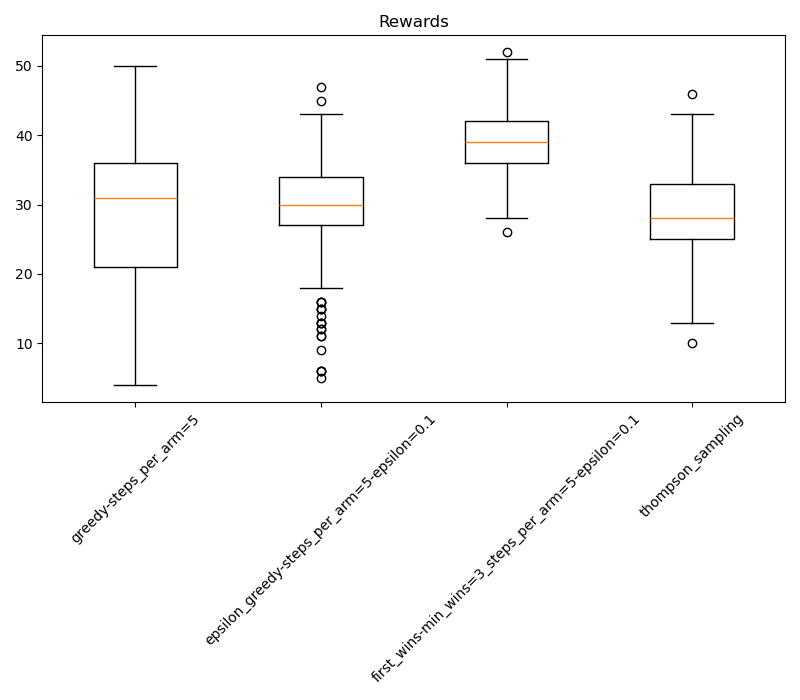

In [7]:
# plt.bar([f"{ag.name}" for ag in agents], P50)

fig, ax = plt.subplots(figsize=(8,7))
VP = ax.boxplot([rewards_all_trials[:,i] for i in range(rewards_all_trials.shape[1])],
                 labels=[f"{ag.name}"for ag in agents])
plt.xticks(rotation=45)
plt.title("Rewards")
plt.tight_layout()
plt.show()

In [8]:
print(f"Optimal reward: {optimal_rewards}\n")

for P_val in [50, 25, 75]:
  print(f"P{P_val} values")
  
  for ag_indx, agent in enumerate(agents):
    quantile = np.quantile(rewards_all_trials[:, ag_indx], P_val/100)
    print(f" {agent.name}: {quantile}")

  print("")

Optimal reward: 40.0

P50 values
 greedy-steps_per_arm=5: 31.0
 epsilon_greedy-steps_per_arm=5-epsilon=0.1: 30.0
 first_wins-min_wins=3_steps_per_arm=5-epsilon=0.1: 39.0
 thompson_sampling: 28.0

P25 values
 greedy-steps_per_arm=5: 21.0
 epsilon_greedy-steps_per_arm=5-epsilon=0.1: 27.0
 first_wins-min_wins=3_steps_per_arm=5-epsilon=0.1: 36.0
 thompson_sampling: 25.0

P75 values
 greedy-steps_per_arm=5: 36.0
 epsilon_greedy-steps_per_arm=5-epsilon=0.1: 34.0
 first_wins-min_wins=3_steps_per_arm=5-epsilon=0.1: 42.0
 thompson_sampling: 33.0



## Results

Epsilon-Greedy and Thompson often have similar performances in the settings studied above, so it's hard to conclude with certainty if one is better vs another. Let's study it more systematically below.

## Random distributions

Instead of studying performance on one set of reward probabilities, as we did above, do a few hundred trials, and in each trial generate a random set of probabilities of reward.

In the plots below,  compute (Total reward)/(Total number of steps), i.e. average reward up to that point.  Since we run many trials, compute the P50 of that distribution of that value across trials.

In [9]:
NUMBER_ARMS = 5

NUM_TRIALS = 500
NUMBER_SEARCH_STEPS_TOTAL = 1000   #max number of total steps in each trial
NUMBER_AGENTS = 7

MIN_NUM_SUCCESSES_TO_END_SEARCH = 2

In [10]:

avg_reward_all_trials_all_steps_all_agents = np.zeros((NUM_TRIALS, NUMBER_SEARCH_STEPS_TOTAL, NUMBER_AGENTS))

for trial in range(NUM_TRIALS):
  
  #generate random probabilities for each arm for this trial. 
  #Want 1 arm to have a higher payout probability than others.
  PROBS = np.random.random(NUMBER_ARMS)*1/3   #most arms have payout probability sampled from range [0, 1/3]
  PROBS[4] = np.random.random()*2/3           #Last arm has probability sampled from range [0, 2/3] -> often has higher payout than other arms

  b = BernoulliBandit(NUMBER_ARMS, PROBS)
  
  ag_g = GreedyAgent(b, num_search_steps_per_arm=5, name="greedy-steps_per_arm=5")
  
  ag_eg1 = EpsilonGreedyAgent(b, num_search_steps_per_arm=3, epsilon=0.1, name="epsilon_greedy-steps_per_arm=3-epsilon=0.1")
  ag_eg2 = EpsilonGreedyAgent(b, num_search_steps_per_arm=5, epsilon=0.1, name="epsilon_greedy-steps_per_arm=5-epsilon=0.1")
  ag_eg3 = EpsilonGreedyAgent(b, num_search_steps_per_arm=10, epsilon=0.1, name="epsilon_greedy-steps_per_arm=10-epsilon=0.1")
  ag_eg4 = EpsilonGreedyAgent(b, num_search_steps_per_arm=5, epsilon=0.05, name="epsilon_greedy-steps_per_arm=5-epsilon=0.05")

  ag_firstwins = FirstWSuccessesAgent(b, NUMBER_SEARCH_STEPS_PER_ARM, EPSILON, MIN_NUM_SUCCESSES_TO_END_SEARCH, name=f"first_wins-min_wins={MIN_NUM_SUCCESSES_TO_END_SEARCH}_steps_per_arm={NUMBER_SEARCH_STEPS_PER_ARM}-epsilon={EPSILON}" )
  
  ag_t = ThompsonSamplingAgent(b, name="thompson_sampling")
  
  agents = [ag_g, ag_eg1, ag_eg2, ag_eg3, ag_eg4, ag_firstwins, ag_t]
  num_agents = len(agents)
  assert num_agents == NUMBER_AGENTS
  
  #Run the search
  for step in range(NUMBER_SEARCH_STEPS_TOTAL):
    rewards = b.get_all_rewards()
    for agent_idx, agent in enumerate(agents):
      arm_indx = agent.get_arm_to_pull(step)
      reward = rewards[arm_indx]
      agent.store_pull_results(arm=arm_indx, reward=reward)

      avg_reward_all_trials_all_steps_all_agents[trial, step, agent_idx] = agent.total_reward / (step+1.0)

  #reset agents to start next trial
  for agent_idx, agent in enumerate(agents):   
    agent.reset()

In [11]:
P50_rewards = np.quantile(avg_reward_all_trials_all_steps_all_agents, .5, 0)
P25_rewards = np.quantile(avg_reward_all_trials_all_steps_all_agents, .25, 0)
P75_rewards = np.quantile(avg_reward_all_trials_all_steps_all_agents, .75, 0)

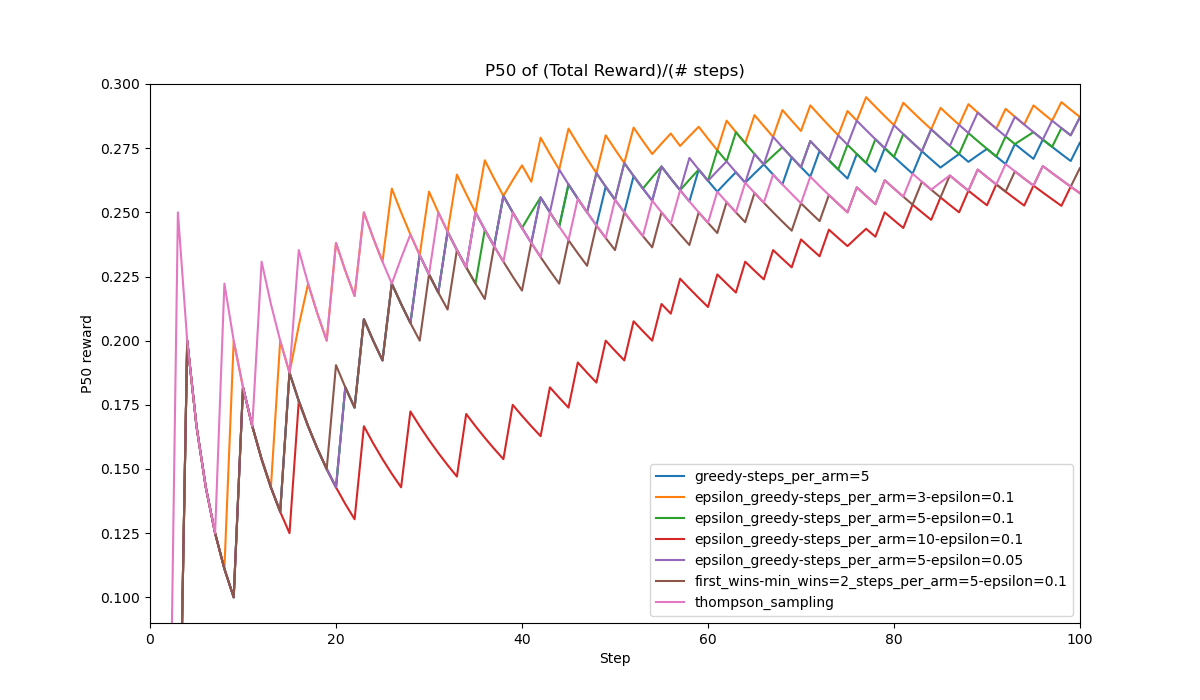

In [18]:
plt.figure(figsize=(12,7))
for agent_idx, agent in enumerate(agents):

  plt.plot(np.arange(0,NUMBER_SEARCH_STEPS_TOTAL, 1), P50_rewards[:, agent_idx], label=agent.name,)

plt.legend()
plt.title("P50 of (Total Reward)/(# steps)")
plt.xlabel("Step")
plt.ylabel("P50 reward")
plt.xlim(0, 100)
plt.ylim(0.09,.30)
plt.show()

### Results for short time horizon
* Thompson sampling seems to perform the best on very short time horizons (< ~ 25 steps), and not bad through 100. But several versions epsilon-greedy catche up fairly quickly, and even overtakes Thompson -- that seems kind of surprising!
* For games with very short time horizons, the best epsilon greedy algorithms have a small number of exploration steps per arm. E.g. for games with < 60 step, 3 exploration steps per arm is better than 5, which is better than 10. That makes sense: in short games, you must limit the time exploring so there is enough time to exploit.
* For short games, it also appears smaller values of epsilon are better: do less random exploration, more exploitation.  That makes sense for short games.
* The made up heuristic FirstWSuccessesAgent performs ok for a small number of steps but is not as good as epsilon greedy with a small number (3) of exploration steps per arm.


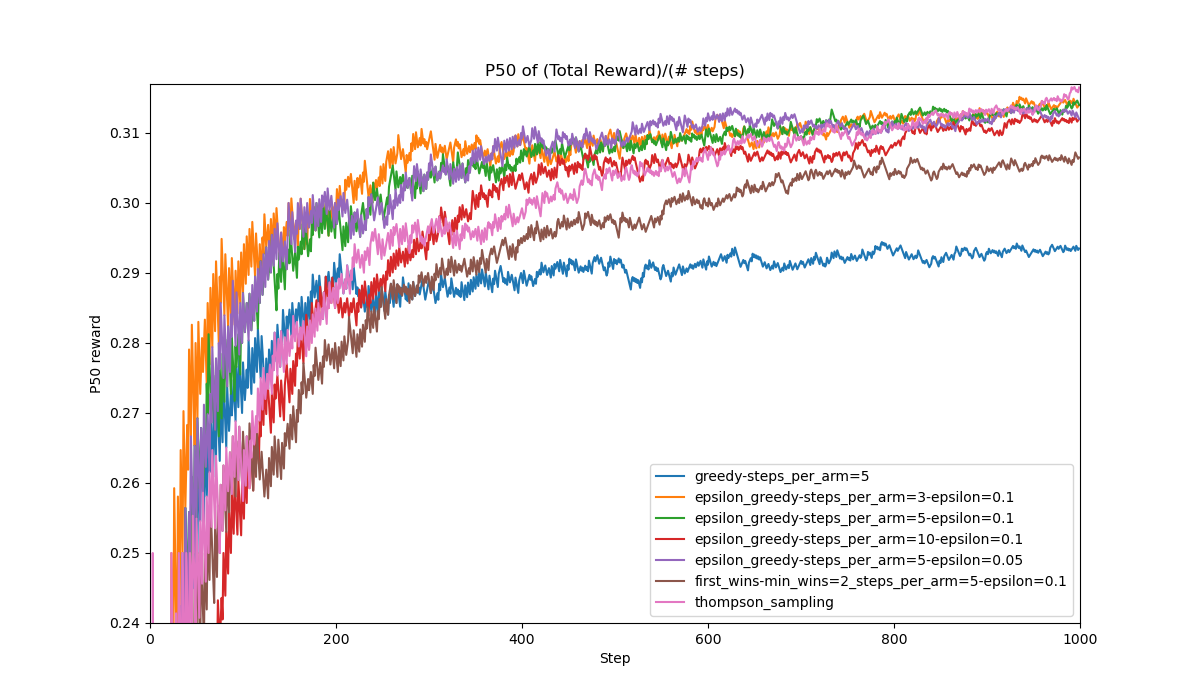

In [24]:
plt.figure(figsize=(12,7))
for agent_idx, agent in enumerate(agents):
  plt.plot(np.arange(0,NUMBER_SEARCH_STEPS_TOTAL, 1), P50_rewards[:, agent_idx], label=agent.name,)

plt.legend()
plt.title("P50 of (Total Reward)/(# steps)")
plt.xlabel("Step")
plt.ylabel("P50 reward")
plt.ylim(.24, .317)
plt.xlim(0,1000)
plt.show()

### Results over long time horizons
* Thompson sampling eventually takes the lead, but not until ~ step 1000.
* Several flavors of epsilon-greedy are competitive with, or even better than Thompson sampling, up until step 1000.
    * So this validates the claim from the paper that epsilon-greedy can be pretty competitive to more complex methods (like Thompson sampling), at least for simulated data.  
    * That's also consistent with https://lilianweng.github.io/posts/2018-01-23-multi-armed-bandit/, which found Epsilon-Greedy can outcompete Thompson sampling over moderate time horizons, but Thompson overtakes over long horizons.

* It would be interesting to compute rewards with optimal solutions and see how they fare vs these simpler algorithms ...



And for good measure, look at the P25, since it would be great to have algorithms whose lower rewards are still good.

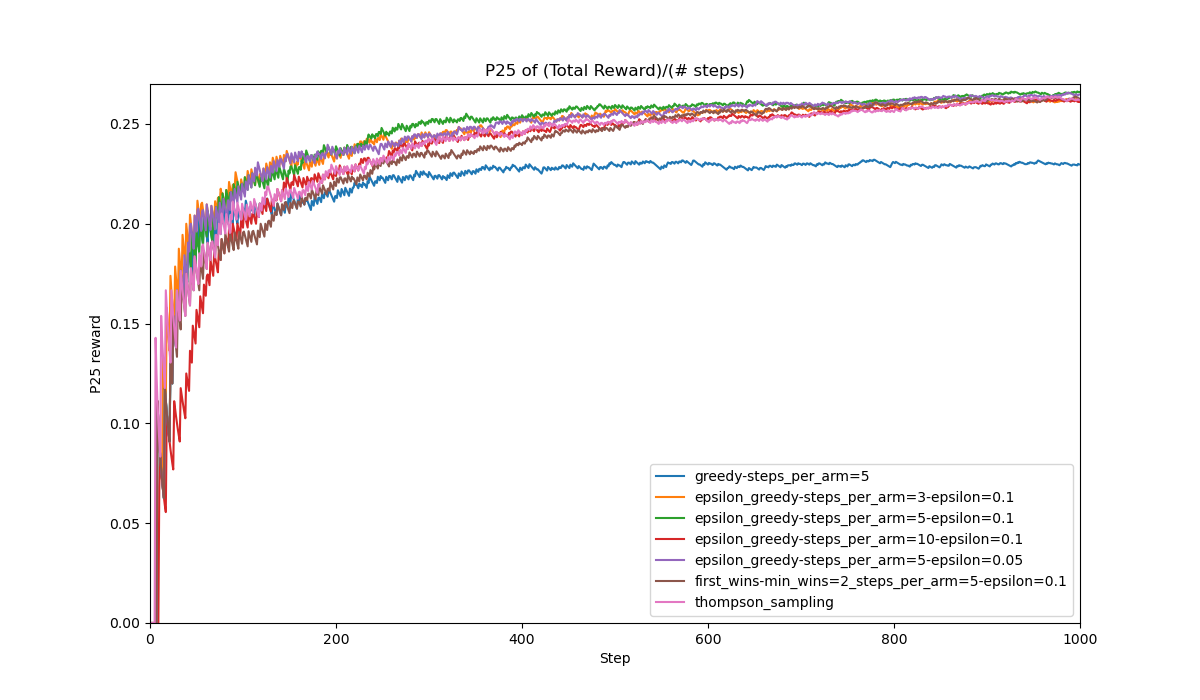

In [30]:
plt.figure(figsize=(12,7))
for agent_idx, agent in enumerate(agents):

  plt.plot(np.arange(0,NUMBER_SEARCH_STEPS_TOTAL, 1), P25_rewards[:, agent_idx], label=agent.name,)

plt.legend()
plt.title("P25 of (Total Reward)/(# steps)")
plt.xlabel("Step")
plt.ylabel("P25 reward")
plt.ylim(.0, .27)
plt.xlim(0,1000)
plt.show()

Interesting: once again, Thompson sampling looks really good through 40 steps, then Epsilon-Greedy outperforms.